In [234]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np

import IPython.display as ipd

In [235]:
filename = "./sounds/windowing_test.wav"
fs, data = wavfile.read(filename)
print(fs)
data.shape

data = data[:, 0] # Working on channel 1

48000


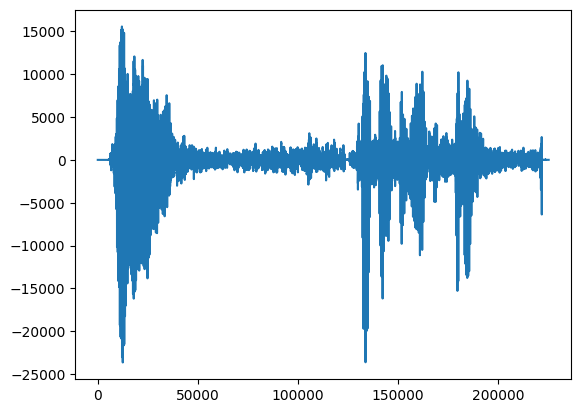

In [236]:
ipd.display(ipd.Audio(data, rate=fs))

plt.plot(data)

Window length in samples: 1440


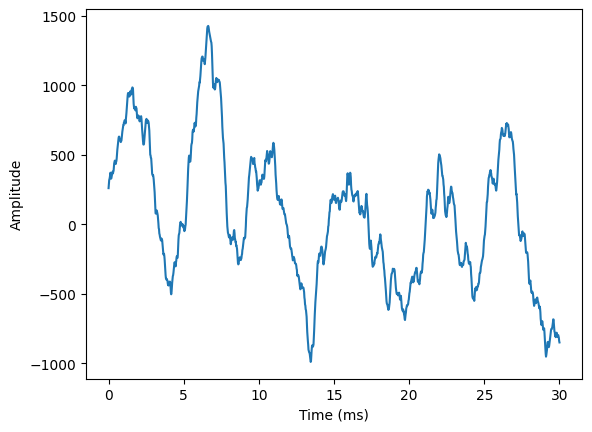

In [237]:
window_length_ms = 30

window_length = int(window_length_ms*fs/1000)
print(f"Window length in samples: {window_length}")

data_length = data.shape[0]

# Choose segment from RANDOM position in sample
starting_position = np.random.randint(data_length - window_length)

time_vector = np.linspace(0, window_length_ms, window_length)

plt.plot(time_vector, data[starting_position:(starting_position+window_length)])
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

360
7.5


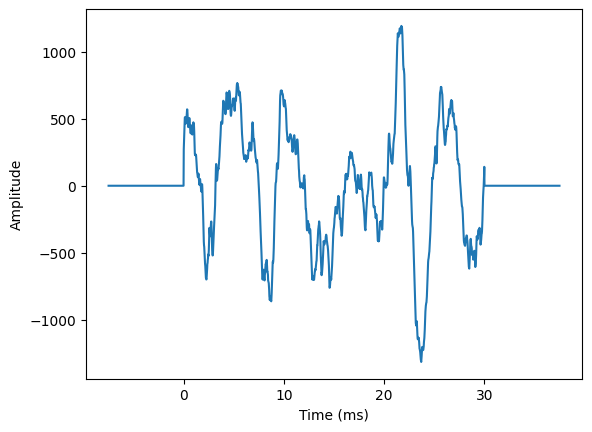

In [238]:
zero_length = int(window_length/4)
print(zero_length)
zero_length_ms = window_length_ms/4
print(zero_length_ms)

# Choose segment from random position in sample
starting_position = np.random.randint(data_length - window_length)

time_vector = np.linspace(-zero_length_ms, 
                            window_length_ms+zero_length_ms, 
                            window_length+2*zero_length)

zero_vector = np.zeros([zero_length, ])
data_vector = np.concatenate((zero_vector, data[starting_position:(starting_position+window_length)], zero_vector))

plt.plot(time_vector, data_vector)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

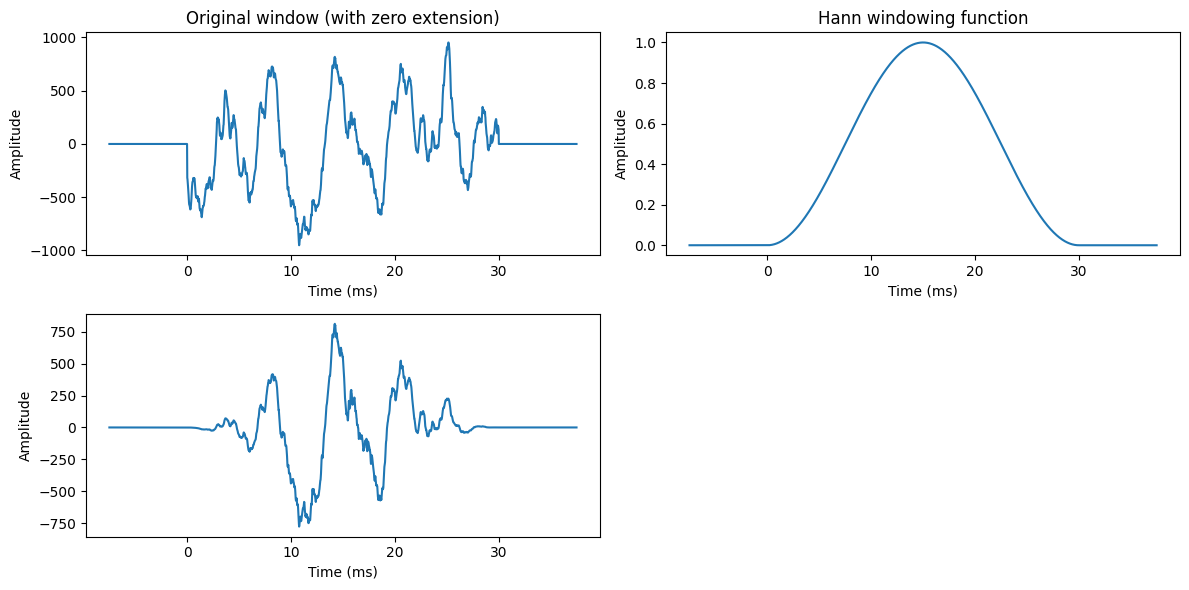

In [239]:
windowing_fn = np.sin(np.pi * np.arange(0.5, window_length, 1)/window_length)**2
windowing_fn_extended = np.concatenate((zero_vector, windowing_fn, zero_vector))

starting_position = zero_length + np.random.randint(data_length - window_length - 2*zero_length)

zero_vector = np.zeros([zero_length, ])
data_vector = np.concatenate((zero_vector, data[starting_position:(starting_position+window_length)], zero_vector))

plt.figure(figsize=[12, 6])

plt.subplot(221)
plt.plot(time_vector, data_vector)
plt.title("Original window (with zero extension)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(time_vector, windowing_fn_extended)
plt.title("Hann windowing function")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(223)
plt.plot(time_vector, data_vector*windowing_fn_extended)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Test each visualization

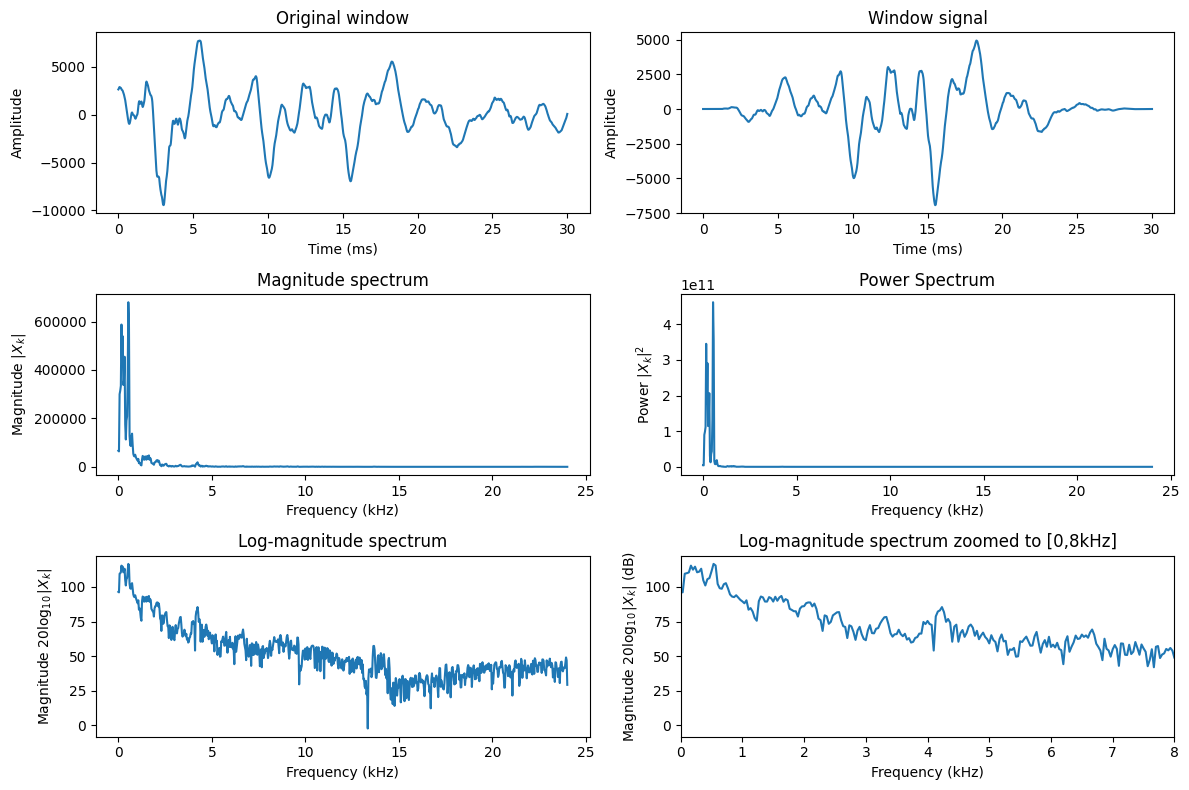

In [240]:
window_length_ms = 30
window_length = int(window_length_ms*fs/1000)

window_fn = np.sin(np.pi*np.arange(0.5, window_length, 1)/window_length)**2

starting_position = zero_length + np.random.randint(data_length - window_length)

data_vector = data[starting_position:(starting_position+window_length), ]
time_vector = np.linspace(0, window_length_ms, window_length)
frequency_vector = np.linspace(0, fs/2000, int(window_length/2 + 1))

plt.figure(figsize=[12, 8])

plt.subplot(321)
plt.plot(time_vector, data_vector)
plt.title("Original window")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(322)
plt.plot(time_vector, data_vector*windowing_fn)
plt.title("Window signal")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(323)
plt.plot(frequency_vector, np.abs(scipy.fft.rfft(data_vector*windowing_fn)))
plt.title("Magnitude spectrum")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude $|X_k|$")

plt.subplot(324)
plt.plot(frequency_vector, np.abs(scipy.fft.rfft(data_vector*windowing_fn))**2)
plt.title("Power Spectrum")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power $|X_k|^2$")

plt.subplot(325)
plt.plot(frequency_vector,20*np.log10(np.abs(scipy.fft.rfft(data_vector*windowing_function))))
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
ax = plt.axis() # save ax with list value [xmin, xmax, ymin, ymax]

plt.subplot(326)
plt.plot(frequency_vector,20*np.log10(np.abs(scipy.fft.rfft(data_vector*windowing_function))))
plt.title('Log-magnitude spectrum zoomed to [0,8kHz]')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$ (dB)')
ax = [0, 8, ax[2], ax[3]] # This will ax with xmin=0, xmax=8, ymin=ymin of above ax and ymax=ymax of above ax
plt.axis(ax)

plt.tight_layout()
plt.show()

# Speech feature in the spectrum

## Envelop

In [241]:
from scipy.linalg import solve_toeplitz, toeplitz

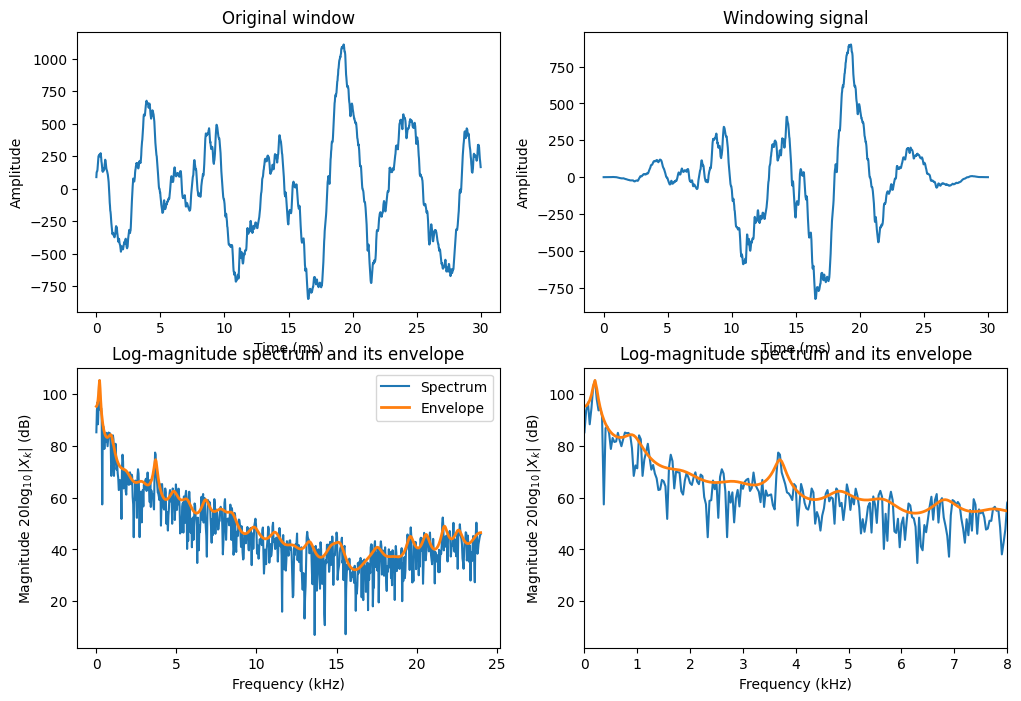

In [243]:
windowing_fn = np.sin(np.pi*np.arange(0.5, window_length, 1)/window_length)**2

starting_position = zero_length + np.random.randint(data_length - window_length)

data_vector = data[starting_position:(starting_position+window_length), ]
time_vector = np.linspace(0, window_length_ms, window_length)
frequency_vector = np.linspace(0, fs/2000, int(window_length/2 + 1))

plt.figure(figsize=[12, 8])

plt.subplot(221)
plt.plot(time_vector, data_vector)
plt.title("Original window")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(time_vector, data_vector*windowing_fn)
plt.title("Windowing signal")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

# Envelop calculation
autocorrelation = scipy.fft.irfft(np.abs(scipy.fft.rfft(data_vector*window_fn))**2)
lpc_order = int(fs/1000 + 2)
u = np.zeros([lpc_order+1, 1])
u[0] = 1
lpc_model = solve_toeplitz(autocorrelation[0:lpc_order+1], u)
lpc_model /= lpc_model[0]
envelope_spectrum = np.abs(scipy.fft.rfft(lpc_model, window_length, axis=0))**-1
signal_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_fn))
envelope_spectrum *= np.max(signal_spectrum)/np.max(envelope_spectrum)

plt.subplot(223)
plt.plot(frequency_vector, 20*np.log10(signal_spectrum), label="Spectrum")
plt.plot(frequency_vector, 20*np.log10(envelope_spectrum), linewidth=2, label="Envelope")
plt.legend()
plt.title("Log-magnitude spectrum and its envelope")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude $20\\log_{10}|X_k|$ (dB)")
ax = plt.axis()

plt.subplot(224)
plt.plot(frequency_vector, 20*np.log10(signal_spectrum), label="Spectrum")
plt.plot(frequency_vector, 20*np.log10(envelope_spectrum), linewidth=2, label="Envelope")
plt.title("Log-magnitude spectrum and its envelope")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude $20\\log_{10}|X_k|$ (dB)")
ax = [0, 8, ax[2], ax[3]]
plt.axis(ax)

plt.tight_layout
plt.show()